<a href="https://colab.research.google.com/github/RNEequalRNA/youtube-data-acquisition/blob/main/sample2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
%autoreload 2

In [10]:
import helper
from helper import *

In [11]:
# 긍정적, 부정적 단어 데이터셋 불러오기
positiveWords = pd.read_csv('positive.txt')['words']
negativeWords = pd.read_csv('negative.txt')['words']

In [12]:
videoIdList = retrieve_playlist_videos('PLS3XGZxi7cBVTzEE4Sim9UuNKnUJq9Vkh')  # 플레이리스트에서 처음 50개 영상의 ID 수집

In [7]:
# API를 통해 비디오의 모든 댓글, 통계 정보(좋아요, 조회수 등)을 수집한다. API 호출 오류를 대비하여 최대 10번까지 재시도한다.
statisticsList = []
commentsList = []
commentsTimestamp = []

for id in videoIdList:
    statisticsList.append(retrieve_statistics(id))
    
    retries = 0
    while True:
        flag = True
        if retries >= 10:
            print("MAX RETRIES REACHED")
            commentsList.append([])
            commentsTimestamp.append([])
            break
        try:
            comment, timestamp = get_comments(id)
            commentsList.append(comment)
            commentsTimestamp.append(timestamp)
        except AssertionError:
            flag = False
            retries += 1
        finally:
            if flag:
                break

In [13]:
# 데이터 파일로부터 데이터 불러오기
with open('data/videoid.txt', 'r') as f:
    exec(f"videoIdList = {f.read()}")
with open('data/statistics.txt', 'r') as f:
    exec(f"statisticsList = {f.read()}")
with open('data/comments.txt', 'r') as f:
    exec(f"commentsList = {f.read()}")
with open('data/timestamp.txt', 'r') as f:
    exec(f"commentsTimestamp = {f.read()}")

In [14]:
len(commentsList), sum(map(lambda x: len(x), commentsList))

(50, 22326)

In [15]:
allComments = []
for comments in commentsList: allComments += comments

# (단어, 빈도)를 담고 있는 전체 영상에 대한 빈도수 데이터프레임 생성
freqDataFrame = get_freq(allComments)
freqDataFrame

,word,freq
1131,israel,3743
37,people,2607
424,god,1649
19,one,1621
290,world,1521
...,...,...
11117,diminishing,1
11119,paliestine,1
11120,incorrectly,1
11122,stap,1


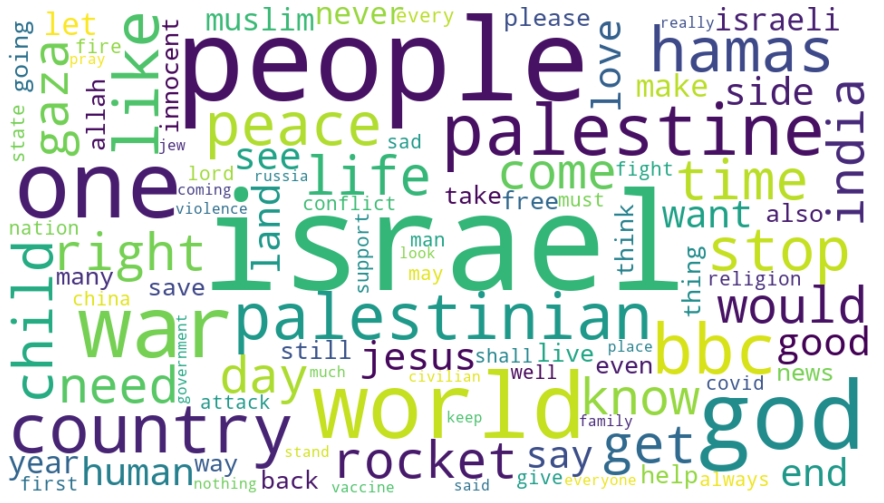

In [16]:
# 빈도수 데이터프레임을 기반으로 Word Cloud 생성
draw_wordcloud(freqDataFrame)

In [17]:
words = []
times = []
for i in tqdm(range(len(videoIdList))):
    for j in range(len(commentsList[i])):
        time = parse(commentsTimestamp[i][j]).timestamp()
        
        for word in get_words(commentsList[i][j]):
            words.append(word)
            times.append(time)


# (단어, 단어의 출현 시간(댓글이 작성된 시간))을 담고 있는 데이터프레임 생성
wordtimeDataFrame = pd.DataFrame(columns=['word', 'time'], data={
    'word': words,
    'time': times
})

100%|██████████| 50/50 [00:05<00:00,  9.23it/s]


In [18]:
PARTITION_SIZE = 15
bins = np.linspace(min(wordtimeDataFrame['time']), max(wordtimeDataFrame['time']), PARTITION_SIZE + 1)  # 수집된 시간의 최소와 최대를 PARTITION_SIZE개의 구간으로 나누기

In [27]:
for word in freqDataFrame['word'].head(10):  # head 메소드로 가장 빈도수 높은 10개만
    display(wordtimeDataFrame[wordtimeDataFrame['word'] == word].hist(bins=bins))  # 아까 나눈 구간별로 빈도수 히스토그램 그리기
    plt.title(word)

SyntaxError: unexpected EOF while parsing (<ipython-input-27-e63dfbe3ee40>, line 3)

In [20]:
# vecDict: Dict[str, np.ndarray]에서 vecDict[word]는 아까 나눈 구간별 빈도수를 PARTITION_SIZE차원의 벡터로 만들고, 이를 정규화(크기를 1로 만듦)시킨 것
vecDict = dict()
for word in tqdm(freqDataFrame['word'].head(100)):
    vecDict[word] = get_freq_vec(wordtimeDataFrame, word, bins)

word1 = []
word2 = []
similarity = []
for w1 in vecDict:
    for w2 in vecDict:
        if w1 == w2:
            break

        word1.append(w1)
        word2.append(w2)
        similarity.append(np.dot(vecDict[w1], vecDict[w2]))  # 아까 만든 벡터의 코사인 유사도를 구함

similarityDataFrame = pd.DataFrame(columns=['word1', 'word2', 'similarity'], data={
    'word1': word1,
    'word2': word2,
    'similarity': similarity
}).sort_values(by='similarity', ascending=False)  # 유사도의 내림차순으로 정렬

similarityDataFrame[:30]

100%|██████████| 100/100 [00:01<00:00, 55.74it/s]


,word1,word2,similarity
10,war,israel,0.994634
7,world,people,0.994633
4196,really,like,0.993900
235,need,world,0.993867
875,make,time,0.993000
5,one,god,0.992884
36,palestinian,israel,0.992735
300,gaza,israel,0.992392
8,world,god,0.991891
232,need,people,0.991869


In [21]:
freqList = [get_freq(comments) for comments in tqdm(commentsList)]  # freqList[i]는 i번째 영상의 빈도수 데이터프레임

100%|██████████| 50/50 [00:03<00:00, 13.03it/s]


In [22]:
tf_idf('israel', freqList)

array([   3.91202301,   43.03225306,   82.15248311,    0.        ,
          3.91202301,    0.        ,   19.56011503,   15.64809202,
          0.        ,   35.20820705,   35.20820705,    0.        ,
          3.91202301,   27.38416104,    0.        ,    3.91202301,
        101.71259814,   58.68034508,    3.91202301, 1236.19926972,
          7.82404601,   15.64809202,    0.        ,   27.38416104,
          0.        ,    0.        ,   19.56011503,    0.        ,
         35.20820705, 1255.75938474, 2409.80617134,   23.47213803,
         82.15248311,  418.58646158, 2069.46016987,    0.        ,
         23.47213803, 2159.436699  ,    7.82404601,  872.38113021,
       2296.35750419,   11.73606902,    0.        ,    3.91202301,
          3.91202301,    3.91202301,    0.        ,    0.        ,
          3.91202301, 1216.63915469])

In [ ]:
# 데이터 저장
with open('data/videoid.txt', 'w') as f:
    f.write(str(videoIdList))
with open('data/statistics.txt', 'w') as f:
    f.write(str(statisticsList))
with open('data/comments.txt', 'w') as f:
    f.write(str(commentsList))
with open('data/timestamp.txt', 'w') as f:
    f.write(str(commentsTimestamp))

In [ ]:
get_words("Good muffins cost $3.88\nin New York.")